In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import artm

# change log style
lc = artm.messages.ConfigureLoggingArgs()
lc.minloglevel = 3
lib = artm.wrapper.LibArtm(logging_config=lc)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from copy import deepcopy
from topicnet.cooking_machine.models.topic_model import TopicModel
from topicnet.cooking_machine.cubes import RegularizersModifierCube
from topicnet.cooking_machine.models.blei_lafferty_score import BleiLaffertyScore
from topicnet.cooking_machine.config_parser import build_experiment_environment_from_yaml_config

from topicnet.cooking_machine.experiment import Experiment
from topicnet.cooking_machine.cubes import *
from topicnet.cooking_machine.dataset import Dataset

%load_ext autoreload
%autoreload 2

In [3]:
import topicnet.cooking_machine.cubes as tncubes

In [4]:
from IPython.core.display import display, HTML
from IPython.display import clear_output, display_html
display(HTML("""<style>
.container { width:90% !important; }
div.output_scroll .output_subarea { white-space: pre; }
</style>"""))

### Get dataset

In [5]:
DATASET_PATH = "/home/sultan/datasets/PScience/PScience.csv"

In [6]:
dataset = Dataset(DATASET_PATH)
dictionary = dataset.get_dictionary()

In [7]:
print(dataset.get_possible_modalities())
dataset.get_dataset().head()

{'@post_tag', '@author', '@snippet', '@3gramm', '@2gramm', '@title', '@word'}


,vw_text,raw_text
id,,
1.txt,1.txt |@author fuchs preobrazhensky tabachniko...,@title Автограф # «Математический дивертисмент...
2.txt,2.txt |@word книга:2 лекция:3 рассматриваться:...,@title Главы: Маскулинности в российском конте...
3.txt,3.txt |@word развитие появляться пиджина:4 бел...,@title Пиджины и креольские языки | @snippet Л...
4.txt,4.txt |@word стандартный задача:3 состоять:4 р...,@title FAQ: Физиология микроводорослей | @snip...
5.txt,5.txt |@2gramm повседневный_практика государст...,@title Русская государственная идеология | @sn...


### Make initial model

In [8]:
with open("/home/sultan/recipes/ARTM_baseline_smooth_bigram.yml", "r") as f:
    yaml_string = f.read()

specific_topics = [f'topic_{i}' for i in range(27)]
background_topics = [f'bcg_{i}' for i in range(len(specific_topics),len(specific_topics) + 2)]

yaml_string = yaml_string.format(
    modality_list=['@2gramm', '@word', '@post_tag', '@3gramm'],
    main_modality='@word',
    specific_modality='@2gramm',
    dataset_path=DATASET_PATH,
    specific_topics=specific_topics,
    background_topics=background_topics)

print(yaml_string)

# This config follows a strategy described by Murat Apishev
# one of the core programmers of BigARTM library in personal correspondence.
# According to his letter 'decent' topic model can be obtained by
# Decorrelating model topics simultaneously looking at retrieved TopTokens


# Use .format(modality_list=modality_list, main_modality=main_modality, dataset_path=dataset_path,
# specific_topics=specific_topics, background_topics=background_topics)
# when loading the recipe to adjust for your dataset

topics:
# Describes number of model topics, better left to the user to define optimal topic number
    specific_topics: ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26'] 
    background_topics: ['bcg_27', 'bcg_28']

# Here is exam

### Run experiment

In [9]:
from topicnet.cooking_machine.experiment import Experiment
if os.path.exists(f'./MuratDemo_smooth') == True:
    os.system("rm -rf ./MuratDemo_smooth")
experiment, dataset = build_experiment_environment_from_yaml_config(
    yaml_string,
    experiment_id="MuratDemo_smooth",
    save_path="MuratDemo_smooth"
)

In [10]:
experiment.run(dataset)

/home/sultan/miniconda3/lib/python3.6/site-packages/topicnet/cooking_machine/cubes/base_cube.py:206: UserWarning: Perplexity is too high for threshold 1.05
  warnings.warn(warning_message)
/home/sultan/miniconda3/lib/python3.6/site-packages/topicnet/cooking_machine/cubes/base_cube.py:206: UserWarning: Last five scores are equal, interrupting search
  warnings.warn(warning_message)


{<topicnet.cooking_machine.models.topic_model.TopicModel at 0x7f3ef6147f60>}

In [11]:
experiment.show()

Experiment MuratDemo_smooth

Experiment was made with BigARTM 0.9.0
Tree:
                                ┌##11h38m15s_13d11m2019y###
                                ├##11h39m11s_13d11m2019y###
                                ├##11h40m06s_13d11m2019y###
<<<<<<<<<<<root>>>>>>>>>>>──────┤
                                ├##11h41m02s_13d11m2019y###
                                │                                                                                                       ┌##11h44m13s_13d11m2019y###
                                │                                                                                                       ├##11h45m19s_13d11m2019y###
                                ├##11h41m58s_13d11m2019y###─────────────────────────────────────────────────────────────────────────────┤
                                │                                                                                                       ├##11h46m26s_13d11m2019y###
                      

In [12]:
best_model = experiment.select(experiment.criteria[-1][0])[0]

In [13]:
best_model.describe_regularizers()

tau  gamma
model_id                   regularizer_name                    
##11h45m19s_13d11m2019y### smooth_phi_bcg       9.949604    NaN
                           smooth_theta_bcg    93.597598    NaN
                           decorrelation_phi    0.030000    0.0
                           smooth_phi_@2gramm   0.250000    NaN

In [14]:
best_model.describe_scores()

last_value
model_id                   score_name                                                                               
##11h45m19s_13d11m2019y### PerplexityScore@all                                                           1.52022e+11
                           SparsityThetaScore                                                              0.0658252
                           SparsityPhiScore@2gramm                                                          0.725937
                           PerplexityScore@2gramm                                                            2303.03
                           TopicKernel@2gramm.average_coherence                                                    0
                           TopicKernel@2gramm.average_contrast                                              0.523009
                           TopicKernel@2gramm.average_purity                                                 0.48134
                           TopicKernel@2gramm.average_size                                                   319.862
                           TopicKernel@2gramm.coherence            {'topic_0': 0.0, 'topic_1': 0.0, 'topic_2': 0....
                           TopicKernel@2gramm.contrast             {'topic_0': 0.4790801405906677, 'topic_1': 0.5...
                           TopicKernel@2gramm.purity               {'topic_0': 0.36482369899749756, 'topic_1': 0....
                           TopicKernel@2gramm.size                 {'topic_0': 143.0, 'topic_1': 239.0, 'topic_2'...
                           TopicKernel@2gramm.tokens               {'topic_0': ['демократический_общество', 'заст...
                           SparsityPhiScore@word                                                            0.592021
                           PerplexityScore@word                                                              3517.93
                           TopicKernel@word.average_coherence                                                      0
                           TopicKernel@word.average_contrast                                                0.455672
                           TopicKernel@word.average_purity                                                  0.190629
                           TopicKernel@word.average_size                                                     846.655
                           TopicKernel@word.coherence              {'topic_0': 0.0, 'topic_1': 0.0, 'topic_2': 0....
                           TopicKernel@word.contrast               {'topic_0': 0.46681317687034607, 'topic_1': 0....
                           TopicKernel@word.purity                 {'topic_0': 0.13469649851322174, 'topic_1': 0....
                           TopicKernel@word.size                   {'topic_0': 89.0, 'topic_1': 134.0, 'topic_2':...
                           TopicKernel@word.tokens                 {'topic_0': ['олигархия', 'ксенофонт', 'аристо...
                           SparsityPhiScore@post_tag                                                        0.866333
                           PerplexityScore@post_tag                                                          54.5616
                           TopicKernel@post_tag.average_coherence                                                  0
                           TopicKernel@post_tag.average_contrast                                            0.824781
                           TopicKernel@post_tag.average_purity                                              0.913015
                           TopicKernel@post_tag.average_size                                                 35.2069
                           TopicKernel@post_tag.coherence          {'topic_0': 0.0, 'topic_1': 0.0, 'topic_2': 0....
                           TopicKernel@post_tag.contrast           {'topic_0': 0.8007462620735168, 'topic_1': 0.8...
                           TopicKernel@post_tag.purity             {'topic_0': 0.9622633457183838, 'topic_1': 0.9...
           

## Results

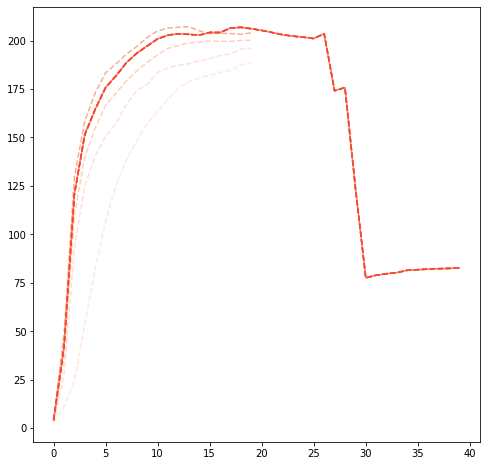

In [15]:
from matplotlib import cm
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['BleiLaffertyScore']
    ls = "-" if tm.model_id == best_model.model_id else "--" 
    plt.plot(score, color=cm.Reds(colors[i]), ls=ls)
plt.show()

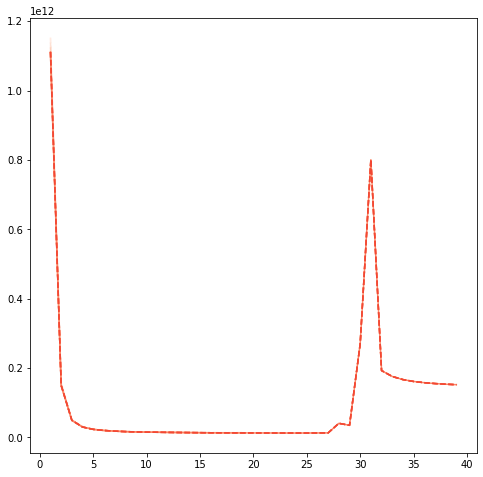

In [16]:
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['PerplexityScore@all']
    score[0] = float("nan")
    ls = "-" if tm.model_id == best_model.model_id else "--" 
    plt.plot(score, color=cm.Reds(colors[i]), ls=ls)
plt.show()

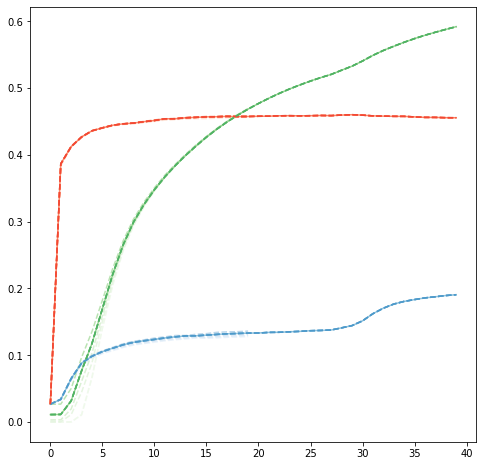

In [17]:
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    ls = "-" if tm.model_id == best_model.model_id else "--" 
    score = tm.scores['TopicKernel@word.average_purity']
    plt.plot(score, color=cm.Blues(colors[i]), ls=ls)
    score = tm.scores['TopicKernel@word.average_contrast']
    plt.plot(score, color=cm.Reds(colors[i]), ls=ls)
    
    score = tm.scores['SparsityPhiScore@word']
    plt.plot(score, color=cm.Greens(colors[i]), ls=ls)

plt.show()

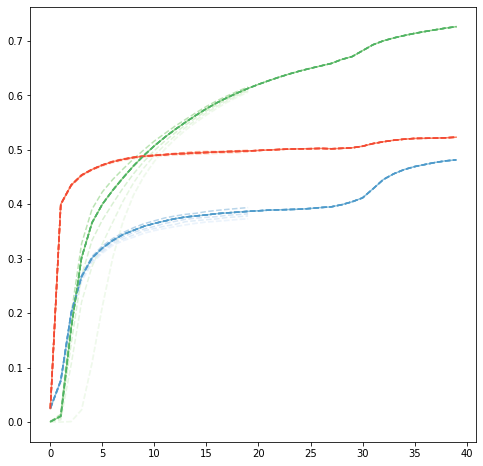

In [18]:
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    ls = "-" if tm.model_id == best_model.model_id else "--" 
    score = tm.scores['TopicKernel@2gramm.average_purity']
    plt.plot(score, color=cm.Blues(colors[i]), ls=ls)
    score = tm.scores['TopicKernel@2gramm.average_contrast']
    plt.plot(score, color=cm.Reds(colors[i]), ls=ls)
    
    score = tm.scores['SparsityPhiScore@2gramm']
    plt.plot(score, color=cm.Greens(colors[i]), ls=ls)

plt.show()

## Investigate model

In [19]:
from topicnet.viewers.top_tokens_viewer import TopTokensViewer
from topicnet.viewers.top_documents_viewer import TopDocumentsViewer

In [20]:
first_model_top_tok = TopTokensViewer(best_model, num_top_tokens=10, method='phi')
first_model_html =  first_model_top_tok.to_html(first_model_top_tok.view())
first_model_top_doc = TopDocumentsViewer(best_model, dataset=dataset).view()

In [21]:
from IPython.display import display_html, display
from topicnet.cooking_machine.dataset import get_modality_vw


n=None
for line, topic_docs in list(zip(first_model_html, first_model_top_doc))[:n]:
    display_html(line, raw=True)
    for doc_id in topic_docs:
        doc_vw = dataset.get_vw_document(doc_id).values[0][0]
        doc_title = get_modality_vw(doc_vw, "@title")
        doc_snippet = get_modality_vw(doc_vw, "@snippet")
        display_html(f"<b>{doc_title}</b><br />{doc_snippet}", raw=True)

,topic_0 @2gramm
политический_философия,0.03663
научный_революция,0.01726
политический_теория,0.01636
политический_мысль,0.01222
политический_философ,0.00988
лео_штраус,0.00973
политический_режим,0.00942
человеческий_природа,0.00663
мишель_фуко,0.00505
историк_наука,0.00498


политическая философия эроса о понятии эроса и эрота в дискуссии о тирании у платона, ксенофонта и аристотеля, идеальном правителе и высшей форме страсти

тирания у платона философ александр павлов о политической философии платона, понимании тирании в диалогах «государство» и «законы» и идеальном политическом режиме

тирания у ксенофонта философ александр павлов о диалоге «гиерон», философии ксенофонта в работах лео штрауса и проекте добродетельной тирании

тирания в античной политической философии философ александр павлов о значении худшего политического режима в трудах платона, ксенофонта и аристотеля

главымеханицизм. декарт конструирует вселенную отрывок из книги «научная революция как событие» историков науки питера деара и стивена шейпина о появлении науки в ее современном понимании

что смотреть«мандерлей» ларса фон триера социолог григорий юдин рекомендует фильм, вскрывающий конфликт между теорией и практикой демократии в современном мире

экономические взгляды сократа философ михаил маяцкий о разногласиях между сократом и софистами, плате за образование и представлениях о богатстве в эпоху античности

политическая философия аристотеля историк александр марей об уравнивающей справедливости, понятии полиса и природе рабства

главы # свобода слуг и свобода граждан отрывок из книги знаменитого итальянского политического философа маурицио вироли «свобода слуг»

faqалмазное правило этики 7 фактов о дополнении к золотому правилу нравственности

,topic_1 @2gramm
нитрид_бора,0.01613
органический_химия,0.0151
кристаллический_структура,0.01359
нобелевский_премия,0.01163
высокий_давление,0.01153
молекулярный_машина,0.01085
высокий_температура,0.01038
химический_связь,0.00863
магнитный_пол,0.0085
атом_углерод,0.0083


водородные топливные элементыот полетов «аполлона» до автомобилей об одном из самых многообещающих альтернативных источников энергии, водородном гибридном автомобиле toyota mirai и защите окружающей среды

реакция интеркалирования химик виктор авдеев о графитовой матрице, сверхсжатом состоянии металлов и интеркалировании природного вермикулита

фуллерены нобелевский лауреат по химии харольд крото о молекулярных решетках, исследовании углеродных звезд и фундаментальной науке

дизайн сверхпроводников, магнитов и взрывчатых веществ химик артем оганов о роли тяжелых элементов, максимизации энергии и повышении температуры сверхпроводимости

обнаружен полимерный раствор, затвердевающий при нагревании о взаимодействии различных фракций, образовании кристаллов и применении веществ с контролируемо изменяющимися свойствами

гетероциклические циркулены химик валентин ненайденко об органической химии, красоте молекул и «серных цветках»

«если я научусь делать деньги — я разучусь делать науку» химик артем оганов о предсказании новых материалов, коммерциализации науки и амбициозных идеях

синтезирован полимер в форме винтовой лестницы об оптически активных веществах, полимерах спиральной структуры и многоэтапном синтезе

превращения в кристаллах материаловед валентин крапошин о полиморфном переходе, закалке стали и причинах плавления льда на поверхности воды

дизайн сверхтвердых материалов химик артем оганов о структуре алмаза, применении сверхтвердых материалов и новых формах углерода

,topic_2 @2gramm
северный_кавказ,0.01608
ближний_восток,0.01519
xvi_век,0.01038
vii_век,0.00888
vi_век,0.00873
восточный_азия,0.00872
саудовский_аравия,0.00862
письменный_источник,0.00838
арабский_весна,0.0076
иван_грозный,0.00747


государства сапотеков и миштеков историк дмитрий беляев о культе предков, стенах черепов и археологических исследованиях в долине оахаки

faqпарадокс конкисты 7 фактов о главных задачах и особенностях испанского завоевания америки

первая империя мезоамерики историк дмитрий беляев об организации пространства теотиуакана, городском быте и особенностях культурной экспансии

«отряд конкистадоров — своего рода акционерная компания, где каждый надеется окупить затраты» интервью с филологом андреем кофманом о причинах успеха конкисты и становлении латиноамериканской культуры

памятники классического периода истории древнего китая историк марк ульянов об эпиграфических надписях ранних периодов, жанре исторических хроник и каноноведческой школе

парадокс конкисты латиноамериканист андрей кофман о христианизации индейцев, экспедиции кортеса и капиталистической форме организации

конкиста и метисация латиноамериканист андрей кофман о христианизации индейцев, культуре сексуальных отношений в америке и внебрачных детях колонистов

кризис мезоамериканских государств классического периода историк дмитрий беляев о процессе балканизации, упадке теотиуакана и самом масштабном батальном памятнике в истории

формирование этнической общности хуася историк марк ульянов о происхождении древних китайцев, археологических находках и территории расселения хуася

царская власть в паленке историк дмитрий беляев о храме надписей, жертвоприношениях богам и пророчествах майя

,topic_3 @2gramm
мировой_война,0.04076
французский_революция,0.02331
xviii_век,0.01344
веймарский_республика,0.01195
европейский_союз,0.01167
екатерина_ii,0.00792
российский_империя,0.00764
третье_сословие,0.00714
третье_рейх,0.00637
нацистский_германия,0.00544


главы # тыл в первую мировую отрывок из книги «первая мировая войнакатастрофа 1914 года» британского историка макса хейстингса о быте мирного населения воюющих стран

репрессивный аппарат третьего рейха историк илья женин об антисемитской политике, хрустальной ночи и лагерях смерти в нацистской германии

якобинский террор историк дмитрий бовыкин о массовых арестах в период французской революции, декретах национального конвента и теории обстоятельств в историографии

главы # дискуссия о сущности террора отрывок из книги «русское общество в зеркале революционного террора. 1879–1881 годы» историка юлии сафроновой

история германии xx века 13 лекций историка ильи женина о ключевых событиях современной истории германии

начало французской революции историк дмитрий бовыкин о движении санкюлотов, конституции 1791 года и псевдонаучных открытиях жан-поля марата

«зондеркоммандо» историк павел полян о лагерях смерти, зондеркоманде аушвица и документах холокоста

автограф # «свитки из пепла. еврейская “зондеркоммандо” в аушвице-биркенау и ее летописцы» историк павел полян о главных документах холокоста, членах зондеркоманды и осмыслении опыта концентрационных лагерей

французская революция xviii века курс лекций историка дмитрия бовыкина о революционном десятилетии, основных хронологических сюжетах и культурных изменениях той эпохи

идея «народного сообщества» в германии историк илья женин о работе немецкого трудового фронта, зарождении идеи социального государства и пропагандистской машине времен третьего рейха

,topic_4 @2gramm
римский_право,0.04667
право_собственность,0.02825
индоевропейский_язык,0.02194
языковой_семья,0.01722
обычный_право,0.01638
правовой_система,0.01237
исторический_языкознание,0.01208
общий_право,0.01124
римский_юрист,0.01091
индоевропейский_семья,0.01008


правовые последствия смешения вещей юрист денис новак о смешении однородных вещей, праве собственности на такое имущество и кондикционном иске

кондикция владения юрист денис новак о защите при неправомерном лишении владения, виндикационном и кондикционном исках и ценности владения имуществом

юриспруденция в древнем риме периода принципата историк права дмитрий полдников о римском праве как «искусстве доброго и справедливого», этапах развития юриспруденции и модельных казусах

фидуциарные отношения юрист дмитрий дождев о привилегиях кредитора, англо-американском трасте и фидуции в германском праве

faqдобросовестность 5 фактов об одном из важнейших наследий римского права и его современном понимании

источники римского права историк александр марей о понятии «плебисцит», конституциях императоров и праве ответа

главы # в поисках родины отрывок из книги «генетическая одиссея человека» антрополога и популяционного генетика спенсера уэллса

вещные права юрист дмитрий дождев о понимании права собственности, феодальной системе имущественных прав и узуфрукте

приобретательная давность юрист дмитрий дождев о владении и праве собственности, способах приобретения и понятии кражи

faqiniuria 7 фактов о деликте римского права по поводу личной обиды

,topic_5 @2gramm
советский_союз,0.02457
гражданский_война,0.01764
советский_власть,0.01564
политика_память,0.01239
русский_формализм,0.00998
русский_литература,0.0083
русский_культура,0.00721
красный_армия,0.00697
культурный_политика,0.00609
начало_война,0.00581


приход сталина к власти историк олег хлевнюк о системе коллективного руководства после смерти ленина, заявлении сталина об отставке и полном контроле над органами госбезопасности

«сталин, коба и сосо. молодой сталин в исторических источниках» историк ольга эдельман о дореволюционной биографии сталина, проблеме верификации источников и задачах исторического исследования

противоречия сталинизма в послевоенный период историк олег хлевнюк о репрессивной политике сталина, социально-экономическом кризисе послевоенного периода и либерализации советского режима после 1953 года

предпосылки десталинизации историк олег хлевнюк о проблемах послевоенного ссср, демонтаже гулага и наследии сталинского режима

повседневный быт московских цензоров филолог алина бодрова об авторах, издателях и цензорах журнала «москвитянин»

литературное наследие пушкина филолог алина бодрова о формировании собрания сочинений, советских изданиях и проблемах текстологии пушкина

эпоха сталина 11 материалов историка олега хлевнюка о зарождении и гибели сталинской эпохи, проблемах ее интерпретации и значении для мировой истории

джон р.р. толкин«история куллерво» филолог мария штейнман о незаконченной рукописи автора «властелина колец» и финском эпосе «калевала»

главыавторские тексты сталина отрывок из книги «сталин, коба и сoco» историка ольги эдельман о дореволюционных текстах будущего вождя и воспоминаниях его современников

западное наследие формальной школы историк александр дмитриев об основателях русского формализма, чешском структурализме и наследии лотмана

,topic_6 @2gramm
естественный_отбор,0.02156
половый_отбор,0.01143
процесс_эволюция,0.00881
теория_эволюция,0.00839
поведение_животное,0.00818
пермский_период,0.00816
человекообразный_обезьяна,0.00769
эволюционный_биология,0.00764
живой_организм,0.00735
юрский_период,0.00734


варвара веденина"половой отбор не всегда противоречит естественному" интервью с биологом варварой ведениной о гипотезах, объясняющих выбор самок, и генетической детерминации механизмов полового отбора

«многие юрские животные продолжили свое развитие и даже имеют потомков в наше время» палеонтолог чжунхэ чжоу о многообразии удивительных животных юрского периода

архат абжанов«строение черепа птицы унаследовали от динозавров» биолог архат абжанов об эволюции птиц, строении их черепа и общих чертах с крокодилами

зависит ли коммуникация псовых от цвета их глаз? о социальном поведении собак и волков, их общении с помощью взгляда и охотничьих навыках

особенности строения голосеменных класса войновскиевых о спорных вопросах в изучении одной из самых своеобразных групп голосеменных растений, произраставших на земле в конце палеозойской эры

палеонтологические обоснования теории эволюции палеонтолог андрей иванцов о доказательствах теории эволюции, геологической истории земли и изменениях трилобитов

faqсоциальное поведение свободноживущих лошадей 5 фактов о различных группах одичавших лошадей и их поведении

находка из кении прольет свет на происхождение бегемотов о новых палеонтологических находках, установлении связей между видами и истории эволюции гиппопотамов

найдено древнейшее свидетельство внутреннего оплодотворения среди позвоночных о разнообразии групп рыб, копулятивных органах и издержках выхода на сушу

главы # сексуальные привилегии отрывок из книги «политика у шимпанзе. власть и секс у приматов» нидерландского приматолога и этолога франса де валя

,topic_7 @2gramm
квантовый_компьютер,0.02038
длина_волна,0.01468
квантовый_точка,0.01089
квантовый_технология,0.01043
углеродный_нанотрубка,0.01029
магнитный_поль,0.00938
квантовый_механика,0.00837
ядерный_энергетика,0.00783
электромагнитный_волна,0.00774
квантовый_состояние,0.00754


однослойные углеродные нанотрубки альберт насибулин о синтезе углеродных нанотрубок, аэрозольном методе и прозрачной электронике

faqатомная энергетика сегодня 7 фактов о перспективах развития атомной промышленности в современном мире

«квантовая телепортация используется для передачи секретной информации, которую невозможно украсть» интервью с физиком юджином ползиком о современном понимании идеи телепортации, сериале «star trek» и принципах квантовой криптографии

конденсация экситонных поляритонов физик наталия берлофф о квантовом давлении, свойствах поляритонов и эффекте квантовой блокады

нанофотоника физик владимир белотелов о фотонных вычислениях, плазмонных кристаллах и оптическом компьютере

faqсветоизлучающая органика 6 фактов о разработке новых эффективных источников света

создан наноразмерный элемент, нарушающий симметрию рассеяния света о поляризации света, эффекте фарадея и хиральности

найден новый способ получения наноматериалов ученым удалось проследить процесс роста нанокристаллов при окислении металла

незатухающие токи в металлических кольцах физик андрей семенов о сверхпроводящих кольцах, куперовских парах и многочастичных системах

теория взаимодействия света и вещества в наноструктурах физик алексей кавокин о преобразовании фотонов в веществе, поляритонном лазере и квантовых компьютерах

,topic_8 @2gramm
стволовой_клетка,0.03418
иммунный_система,0.02251
раковый_клетка,0.01715
метод_лечение,0.01092
опухолевый_клетка,0.0105
сахарный_диабет,0.00879
клинический_испытание,0.00873
онкологический_заболевание,0.00842
продолжительность_жизнь,0.00819
костный_мозг,0.00811


механизм противоопухолевого действия белка яда осы об исследовании белка mp1, который выборочно замедляет пролиферацию клеток рака, и перспективах лечения болезни

вич-ассоциированное поражение миокарда и способы его защиты способен ли антиоксидант процистеин предотвращать развитие вич-индуцированной кардиомиопатии

faqгастрит как инфекционная болезнь 5 фактов о причинах возникновения гастрита и язвы и современных способах их лечения

новые возможности в лечении нейродегенеративных заболеваний биолог сергей киселев о репрограммировании клеток, моторных нейронах и новом подходе к разработке лекарств

faqтканевая инженерия сердца 5 фактов о регенеративной медицине, искусственных тканях и перспективах выращивания сердца

sciencehub #09программируемая гибель клеток биолог борис животовский о нарушениях в гибели клеток, роли апоптоза в патогенезе онкологических заболеваний и перспективах исследований в россии

«опухолевые клетки живут для себя, это - клетки-эгоисты» интервью с биологом евгением шевалем о жизненном цикле клетки, онкогенезе и химиотерапии

тканевая инженерия сердца биофизик константин агладзе об искусственных связках, сердечных клетках и полимерных нановолокнах

faqинфекционный процесс 5 фактов об иммунной системе и взаимоотношениях паразита и хозяина

происхождение австралоидной расы антрополог станислав дробышевский о стереотипах, смешении с неандертальцами и специфике австралийских аборигенов

,topic_9 @2gramm
элементарный_частица,0.0485
стандартный_модель,0.04838
бозон_хиггс,0.03693
электрический_заряд,0.01699
хиггсовский_бозон,0.01682
сильный_взаимодействие,0.01536
высокий_энергия,0.01324
слабый_взаимодействие,0.013
космический_луч,0.01228
физика_частица,0.0107


кварк-лептонная симметрия физик дмитрий казаков о поколениях лептонов и кварков, последней открытой элементарной частице и главных фундаментальных взаимодействиях

суперсимметрия физик дмитрий казаков о связи бозонов и фермионов, внедрении теории суперсимметрии и поисках ее подтверждения на коллайдерах

поиск редких процессов на коллайдерах физик лев дудко о моделировании новых процессов, многомерных методах анализа и статистической достоверности

лептоны и нейтрино физик дмитрий казаков о трех поколениях лептонов, эффекте нейтринных осцилляций и роли нейтрино в космологии

адроны физик дмитрий казаков о мире мезонов и барионов, свойствах кварков и адронных резонансах

антиводород физик владимир мележик об экзотических атомах, получении антивещества и расщеплении уровней энергии антиатомов

oбогащение урана физик рафаэль арутюнян о разделении изотопов урана, фториде урана и реакторах на быстрых нейтронах

фундаментальные проблемы физики и астрофизики нейтрино физик валерий рубаков об антинейтрино, космических лучах и нейтринных телескопах

артефактпервый ускоритель эрнеста резерфорда физик григорий трубников об экспериментах резерфорда и начале ядерной физики

экзотические адроны физик роман мизюк о квантовой хромодинамике, цветном заряде и структуре тетракварков

,topic_10 @2gramm
социология_повседневность,0.01431
теория_фрейм,0.01349
материальный_объект,0.01297
старший_возраст,0.01288
король_артур,0.01234
социальный_взаимодействие,0.01228
социальный_жизнь,0.01157
социальный_роль,0.01048
социальный_порядок,0.00979
технический_прогресс,0.00842


5 книг о либерализации старения что читать об изучении пожилого возраста, рассказывает директор центра методологии федеративных исследований ранхигс дмитрий рогозин

понятие фрейма у гоффмана социолог михаил соколов о фрейм-анализе, социальных ролях и театральных метафорах в описании социальной жизни

экстраординарные события и их описания социологический анализ столкновения абсолютного с повседневным

5 книг по философии техники что читать об истории осмысления техники как культурного феномена, рекомендует кандидат философских наук егор лавренчук

стратегические интеракции социолог михаил соколов о субъектах стратегического взаимодействия, разновидностях поступков и теории культурной эволюции

автограф # «социология повседневности и теория фреймов» социолог виктор вахштайн рассказывает, в чём ценность теории фреймов, как развивается фрейм-анализ и о том, от чего стоит воздерживаться учёному

социальные роли социолог михаил соколов о ролевом наборе, ролевой дистанции и экспериментах милгрэма и зимбардо

к теории подозрения социолог виктор вахштайн объясняет, что общего у карла маркса и обитателей петербургской коммуналки

транспонирование социолог виктор вахштайн о марксистской критике повседневности, формулах переноса и рекламе пива

действующие вещи социолог виктор вахштайн объясняет, как материальные объекты конституируют социальные взаимодействия

,topic_11 @2gramm
массовый_культура,0.04035
критический_теория,0.01841
культовый_кино,0.0165
cinema_studies,0.01532
общество_потребление,0.01168
молодёжный_субкультура,0.00945
плохой_кино,0.00884
хороший_вкус,0.00772
популярный_культура,0.00735
живой_мертвец,0.00674


гендерные исследования в cinema studies философ александр павлов о методах психоанализа в cinema studies, образе «последней девушки» и анализе кинематографа с позиций феминизма

главы # скрытые механизмы идеологии в "бойцовском клубе" отрывок из книги «постыдное удовольствиефилософские и социально-политические интерпретации массового кинематографа» философа александра павлова

cinema studies как дисциплина философ и культуролог александр павлов об исследованиях кинематографа на западе, главных теоретиках cinema studies и развитии этой дисциплины в россии

штурмуя публичное пространствослова о гетеротопии плохого вкуса философ александр павлов о теории кэмпа сьюзен сонтаг, русской традиции кинокритики и утопии хорошего вкуса

5 книг о культовом кинематографе что читать о культовом кино, рекомендует доцент философского факультета ниу вшэ александр павлов

феномен happy end культуролог екатерина лапина-кратасюк о популярном кинематографе, фильмах жанра нуар и «кошмаре на улице вязов»

трансформации локальной культуры философ владимир миронов о глобальном коммуникационном пространстве, противостоянии высокой и массовой культуры и оппозиции «свой — чужой»

5 книг об анализе фильма что читать об исследованиях кинематографа на примере анализа конкретных фильмов, рекомендует философ александр павлов

понятие «грайндхаус» в cinema studies философ александр павлов об эксплуатационном кино, концептуальном аппарате cinema studies и взаимодействии высокого и низкого кинематографа

«нет больше высокой и низкой культуры, есть просто культура сегодня» интервью с философом и культурологом александром павловым о философии массовой культуры, славое жижеке и обществе потребления

,topic_12 @2gramm
нервный_клетка,0.03859
нервный_система,0.02534
головной_мозг,0.01646
человеческий_мозг,0.01432
работа_мозг,0.01316
орган_чувство,0.01086
область_мозг,0.00938
потенциал_действие,0.00883
структура_мозг,0.00765
нейронный_сеть,0.00763


faqкомандные нейроны 5 фактов о различных функциях клеток в нервной системе

молекулярные механизмы памяти нейробиолог павел балабан о процессе обучения, «молекуле памяти» и высших функциях мозга

нейрокоммуникаторы, нейроконтроллеры, нейропротезы, экзоскелетоны психофизиолог александр каплан о возможностях мозга, нейроинтерфейсных технологиях и экспериментах с кибернетической рукой

нейрогенетика памяти нейробиолог павел балабан о молекулах памяти, полногеномном анализе и нейродегенаративных заболеваниях

faqматериальная основа памяти 5 фактов о порождении памяти, ее зависимости от белка и молекуле памяти между нервными клетками

командные нейроны нейробиолог павел балабан о сенсорных нейронах, исследованиях беспозвоночных и моделирующих клетках

материальная основа памяти нейробиолог павел балабан о молекулах памяти, материальных следах воспоминаний и механизме процесса обучения

«в эволюции живого не было “допсихического”, “чисто физиологического” этапа» интервью с психофизиологом юрием александровым о наличии и отсутствии сознания, свободе воли и различных способах решения психофизиологической проблемы

каково научное обоснование гипноза? психофизиолог александр каплан о природных состояниях мозга, гипнозе у животных и «каналах доверия»

аппарат эмоций математик александр жданов о формировании мотивации, эмоциях человека и нейронных сетях

,topic_13 @2gramm
чёрный_дыра,0.08172
нейтронный_звезда,0.04874
солнечный_система,0.01203
планетный_система,0.01121
белый_карлик,0.0107
белых_карлик,0.01055
компактный_объект,0.00879
звёздный_скопление,0.0086
химический_состав,0.00775
зона_обитаемость,0.00771


5 сайтов о физике галактик астрофизик алексей моисеев рекомендует 5 лучших интернет-ресурсов, иллюстрирующих строение, образование и эволюцию галактик и их скоплений

планетные системы белых карликов астрофизик роман рафиков о дисках вокруг белых карликов, кольцах сатурна и будущем солнечной системы

полярные диски в галактиках астрофизик ольга сильченко о галактиках с полярными кольцами, холодной аккреции филаментов и химическом составе газа в полярных дисках

свойства двойных звезд астрофизик сергей попов о планетарных туманностях, белых гелиевых карликах и гравитационных волнах

звездное население галактики астроном алексей расторгуев о возрасте звезд, свойствах галактического диска и рассеянных звездных скоплениях

шаровые скопления астроном владимир сурдин о видах звездных скоплений, ядре галактики и жизни на планетах шаровых скоплений

5 сайтов о физике сверхновых астрофизик сергей блинников рекомендует лучшие интернет-ресурсы для знакомства с эволюцией звезд

методы регистрации экзопланет астрофизик сергей попов о транзитных планетах, явлении гравитационного линзирования и телескопе gaia

звездная астрономия 8 лекций астронома алексея расторгуева о звездном населении галактик и процессах, в них происходящих

спиральный узор галактик астроном алексей расторгуев о причинах спирального узора, теории волн плотности и трудностях в изучении нашей галактики

,topic_14 @2gramm
промышленный_революция,0.01936
центральный_банк,0.018
экономический_рост,0.01623
государственный_долг,0.01199
центральный_банка,0.01179
мировой_экономика,0.01136
развивающийся_страна,0.01133
экономический_теория,0.01028
финансовый_рынок,0.00908
заработный_плата,0.00866


faqкурсы валют 7 фактов о причинах роста и падения валют на финансовом рынке

великая депрессия историк юрий рогулёв об антикризисных мерах рузвельта, зарождении социального законодательства в сша и спаде американской экономики в 1930-х годах

зачем нужна макроэкономика экономист сергей гуриев о модели is-lm, фискальном мультипликаторе и анализе макроэкономической политики

от чего зависит цена на нефть? экономист леонид григорьев о причинах колебания цен на нефть и ее роли в современном мире

азиатские экономикиособенности и развитие о причинах азиатского «экономического чуда», темпах роста и трудовой этике

новые тренды в мировой экономике экономист сергей афонцев о темпах роста и основных тенденциях посткризисного развития мировой экономики

faqфинансовая репрессия 8 фактов о механизмах регулирования государством финансовых рынков в развивающихся экономиках

главы # инфляция и гиперинфляция глава из книги "развязка. конец долгового суперцикла и его последствия" финансистов джона молдина и джонатана теппера

экономическое развитие экономист сергей гуриев о разрыве между развитыми и развивающимися странами, уровне жизни и индексе человеческого развития

золотовалютные резервы экономист виктор полтерович о курсе рубля, развитии экспорта и политике накопления

,topic_15 @2gramm
традиционный_культура,0.01687
греческий_миф,0.01487
греческий_мифология,0.01278
чёрный_мор,0.01216
устный_традиция,0.01019
древний_греция,0.00684
звёздный_небо,0.00641
народный_масса,0.00619
народный_культура,0.00616
греческий_слово,0.00608


faqэрос в античной культуре 7 фактов об одном из самых загадочных персонажей греческой мифологии

образ женщины в русских сказках фольклорист варвара добровольская о двух типах сказочных героинь, идеале женщины и происхождении бабы-яги

5 книг о сравнительной мифологии что читать о компаративном изучении мифологий, рекомендует доктор филологических наук сергей неклюдов

faqлогика мифа 7 фактов о тайне мироздания, к которой человек приобщается через миф

магические заговоры в постсоветской россии фольклорист михаил алексеевский о традиционной крестьянской магии, адаптации магических текстов и влиянии западной эзотерики

5 книг об античной мифологии что читать о греческих и римских мифах, рекомендует доктор филологических наук гасан гусейнов

фольклор и обряд фольклорист сергей неклюдов о соотношении слова и действия, текстах заговорной традиции и ритуальной деятельности животных

введение в теоретическую фольклористику 11 лекций фольклориста сергея неклюдова о принципах изучения устных текстов и традиций

мифология «живая» и книжная фольклорист сергей неклюдов об античной мифологии, концепции удалившегося бога и народной религиозности

faqмифология в культуре 7 фактов о роли мифа в истории культуры и мифотворчестве в современном мире

,topic_16 @2gramm
тёмный_материя,0.03609
гравитационный_волна,0.02564
теория_струна,0.02529
реликтовый_излучение,0.0243
тёмный_энергия,0.01959
ранний_вселенная,0.01847
расширение_вселенная,0.01485
скопление_галактика,0.01447
космологический_постоянный,0.01176
большой_взрыв,0.01141


аномалии реликтового излучения астрофизик олег верходанов о низких мультиполях, влиянии объектов ближнего космоса на космологические измерения и учете ненайденных источников

что находится за краем вселенной? физик дмитрий горбунов о размере вселенной, реликтовом излучении и кривизне пространства

автограф # «прорыв за край мира» астрофизик борис штерн о развитии теории космологической инфляции, целевой аудитории научно-популярной литературы и объяснении сложных понятий

новый взгляд на информационный парадокс черных дыр о парадоксе хокинга, излучении черными дырами информации и теории «пушистого клубка»

свидетельства существования параллельных вселенных физик макс тегмарк о ненаблюдаемых предсказаниях, объяснении точной настройки вселенной и квантовом компьютере

точная космология физик макс тегмарк о флуктуациях в ранней вселенной, темной энергии и теории инфляции

основы фундаментальной физики 10 лекций об основных понятиях и проблемах современной физики, отобранных физиком эмилем ахмедовым

почему вселенную называют плоской? астрофизик олег верходанов об искривлении пространства, сценариях расширения вселенной и данных космической миссии planck

faqвселенная до горячей стадии 5 фактов о теориях развития вселенной, инфляционной модели и гравитационных волнах

иерархическое формирование галактик во вселенной астрофизик ольга сильченко о свойствах темной материи, веществе в ранней вселенной и реликтовом фоне

,topic_17 @2gramm
принятие_решение,0.03389
теория_игра,0.01883
принимать_решение,0.0095
поведенческий_экономика,0.00775
рождение_ребёнок,0.0067
быстрый_сон,0.0063
развитие_ребёнок,0.00592
нарушение_сон,0.0059
состояние_сон,0.00466
система_отсчёт,0.00452


эмоции в музыкевосприятие расстояний в тональном поле нейропсихолог марина корсакова-крейн о квинтовом круге, улавливании расстояний в тональном пространстве и важности интуиции в восприятии музыки

инсомнияпричины, лечение и виды бессонницы сомнолог михаил полуэктов об острой и хронической бессоннице, методах исследования и гигиене сна

главыбедность и ребенок до появления на свет отрывок из книги «бедность и развитие ребенка» о том, как социальное неблагополучие влияет на разные аспекты развития ребенка

экономика соблазна экономист ксения паниди о теории перспектив, иллюзии невозвратных потерь и поведении людей в ситуации неопределенности

faqприрода сна 7 фактов об одном из самых важных процессов в жизнедеятельности человека

faqдизайн экономических механизмов 7 фактов о поиске взаимно-оптимальных стратегий при решении экономических игр

гендерные особенности инсомнии сомнолог михаил полуэктов о различиях инсомнии мужчин и женщин, социальных рисках бессонницы и проявлениях сонных расстройств при неврозах

главыпочему пожилые люди эмоционально стабильны отрывок из книги «мозг на пенсии» нейропсихолога андре алемана о склонности пожилых людей к депрессии и влиянии возраста на эмоциональную стабильность

парасомнии сомнолог михаил полуэктов о расстройствах сна, снохождении и синдроме ночной еды

главымузыка на работе отрывок из книги «мы — это музыка» психолога виктории уильямсон о музыке, которую надо слушать в офисе, чтобы повысить свою производительность

,topic_18 @2gramm
русский_язык,0.06825
английский_язык,0.01156
литературный_язык,0.01124
разный_язык,0.01116
носитель_язык,0.0107
дискурсивный_слово,0.00984
устный_речь,0.0094
значение_слово,0.00805
множественный_число,0.00792
германский_язык,0.00786


категория лица лингвист надежда онипенко об отличиях лица от других категорий глагола, образе автора и эгоцентрической грамматической технике

двуязычные словари лингвист дмитрий добровольский о необходимости больших академических словарей, поливариантности немецкого языка и сложностях перевода фразеологизмов

формирование значения слов лингвист светлана евграфова о неправильном употреблении слов, поликодовом гипертексте и бытовой лексикографии

значение синтаксической конструкции лингвист светлана евграфова о членораздельности речи, интуитивном познании синтаксических конструкций и переходе от устной речи к письменной

faqсамоисправления говорящего в спонтанной речи 6 фактов о типах речевых ошибок, допускаемых в устной речи

германские языки лингвист александр пиперски о глагольной системе, фонетике и синтаксисе германских языков

основные особенности балтийских языков лингвист петр аркадьев о балтийских племенах, экзотических сочетаниях и подвижном ударении

синтаксические нули лингвист надежда онипенко об эгоцентрических нулях, незамещенных позициях у ахматовой и нулевом синтаксисе в пословицах

дискурсивные слова лингвист владимир плунгян о частицах в русском языке, значении слов «ну» и «ведь»

бытовая предметная лексика лингвист борис иомдин о словарях бытовой лексики, проблеме изучения иностранных языков и нормативных документах

,topic_19 @2gramm
средний_век,0.0345
католический_церковь,0.02577
xii_век,0.01903
xiii_век,0.01773
фома_аквинский,0.01105
священный_писание,0.01091
xv_век,0.00918
королевский_власть,0.00819
xiv_век,0.00797
западный_европа,0.00739


телесность власти в средние века историк михаил бойцов о качествах тела правителя, знаках власти и трупном синоде

вступление правителя в его город историк михаил бойцов о легитимации власти в средневековье, образе государя как иисуса христа и традициях встречи горожанами своего правителя

faqинститут папства 7 фактов о главе католического мира и процедуре его избрания

главыстроительство церкви и его интерпретации отрывок из книги медиевиста ирины галковой «церкви и всадники. романские храмы пуату и их заказчики» о становлении в европейской культуре феномена родовой церкви

«ритуалы — это и есть власть» интервью с историком михаилом бойцовым об обряде средневековой коронации, практике помазания и статусе королевской власти в европе

«главная загадка варфоломеевской ночикто стоял за покушением на адмирала колиньи» интервью с историком павлом уваровым о религиозных войнах в европе и событиях, предшествовавших варфоломеевской ночи

faqсредневековая иудео-христианская полемика 7 фактов о развитии диалога между христианством и иудаизмом и публичных диспутах средневековья

главы # аристотель в аду? отрывок из книги «тысячелетнее царство (300–1300). очерк христианской культуры запада» историка олега воскобойникова о рецепции аристотелизма в средние века

политическая философия мартина лютера историк александр марей о национализации церкви, роли светской власти и бессилии человеческого разума

погребение правителей в средневековой европе историк михаил бойцов о погребальных церемониях, местах похорон и посмертной власти средневековых государей

,topic_20 @2gramm
искусственный_интеллект,0.03167
социальный_сеть,0.02035
нейронный_сеть,0.01933
программный_обеспечение,0.01451
машинный_обучение,0.01093
база_дать,0.01079
компьютерный_наука,0.00945
анализ_дать,0.0087
язык_программирование,0.00722
операционный_система,0.00698


технология ухода от баз данных в программировании инженер антон чижов о преимуществах оперативной памяти, способах хранения данных и системе «апрентис»

как обучить нейросеть понимать смысл текста программы? о машинном обучении, отличии формальных языков от естественных и обучающих выборках

механизмы управления репутацией в социальных сетях специалист по компьютерным наукам джу йонг ли об анализе социальных сетей, институте репутации и феномене дружбы в facebook

математические методы прогнозирования объемов продаж математик константин воронцов о применении задач машинного обучения в бизнесе, композициях адаптивных моделей и усовершенствовании качества данных

разработка корпоративных информационных систем информатик сергей зыков о возникновении программной инженерии, сложности корпоративных систем и развитии технологий

машина тьюринга 7 фактов об идее универсальной машины, ее функциях и задачах

моделирование интеграции веб-сервисов специалист в компьютерных науках мануэль маццара о языке bpel, пи-исчислениях и перспективах микросервисов

архитектура программного обеспечения программист мэтью басс об усложнении программного обеспечения, возникновении новой дисциплины и системах клиент-сервер

главы # новая нормальность отрывок из книги «удовольствие от x» профессора прикладной математики в корнелльском университете сша стивена строгаца

анализ социальных сетей в интернете специалист по современной технике медиакоммуникаций берни хоган o том, как собирались и анализировались электронные социальные сети и что могут дать их исследования

,topic_21 @2gramm
молекула_днк,0.01735
генетический_информация,0.01378
живой_организм,0.01052
генный_инженерия,0.00806
последовательность_днк,0.00804
кишечный_палочка,0.00803
трансгенный_растение,0.00797
молекулярный_биология,0.0077
двойной_спираль,0.00738
живой_клетка,0.00692


элементарная хроматиновая фибрилла биолог евгений шеваль о фиксации компонентов живой клетки, искусстве замораживания молекул и нуклеосомной фибрилле

сенсорные системы цианобактерий 6 фактов о бактериях, изменивших состав атмосферы земли в прошлом, и их современном изучении

faqкатаболизм микробов 7 фактов об энергетическом обмене микроорганизмов

как днк с синтетическими нуклеотидами встроили в живую клетку? микробиолог константин северинов о центральной догме молекулярной биологии и увеличении информационной емкости днк

структурно-функциональные особенности регуляции бактериальной транскрипции микробиолог константин северинов о бактериофагах, структуре рнк-полимеразы и устройстве лабораторий

биология клетки 10 лекций биолога евгения шеваля об устройстве и функционировании самой элементарной живой системы

аддиктивные гены бактерий микробиолог константин северинов о молекулярной зависимости клеток, токсин-антитоксиновых системах и экспонировании действия антибиотиков

структурная роль некодирующих рнк биолог евгений шеваль о формировании телец ядерного стресса, alu-последовательности и организации структуры ядрышка

термофильные прокариоты биолог елизавета бонч-осмоловская о микробах в термальных источниках, экстремофилах и появлении науки микробиологии

faqранний и средний протерозой 7 фактов о последствиях нарастания количества свободного кислорода в атмосфере, гуронском оледенении и появлении эукариотической клетки

,topic_22 @2gramm
когнитивный_психология,0.01672
решение_задача,0.01659
христианский_восток,0.01227
творческий_мышление,0.01084
долговременный_память,0.00808
прошлое_опыт,0.00756
решать_задача,0.00746
умственный_способность,0.00725
движение_глаз,0.00719
кратковременный_память,0.00693


виды мышления психолог мария фаликман об особом подходе к исследованию мышления в психологии, различиях между теоретическим и практическим мышлением и имеющихся классификациях

методы изучения категорий у детей психолог алексей котов о способности к категоризации, ее изучении и зрительных предпочтениях детей

зрительная память психолог игорь уточкин об экспериментах с памятью, зрительных образах и ложных воспоминаниях

возможности и ограничения зрительной памяти психолог игорь уточкин о долговременной и краткосрочной памяти, экспериментах с запоминанием вещей и событий и объеме хранения

психология создания трудностей и проблем психолог александр поддьяков о различных типах трудностей, их нравственной оценке и разработке игр

что такое синестезия? психолог елена лупенко об исследованиях феномена синестезии, возникновении синестетических образов и врожденной способности воспринимать мир целостно

интерференция в психологии психолог алексей созинов об ассоциативной теории, механизмах запоминания и переключении между задачами

текстовые методики в психологии психолог марина новикова-грунд о сходствах психотерапии и психологии, структуре сюжета «преступление и наказание» и функции лакун в тексте

главы # природа эмоционального интеллекта. когда умный глупеет отрывок из книги "эмоциональный интеллект" дэниела гоулмана - американского психолога, дважды номинанта пулитцеровской премии

можно ли измерить интеллект человека с помощью тестов на iq? что такое интеллект и как разрабатывают тесты на решение задач различного типа

,topic_23 @2gramm
социология_право,0.01776
национальный_государство,0.01509
речь_посполить,0.00982
политический_партия,0.008
этнический_группа,0.00747
российский_федерация,0.00683
российский_империя,0.00616
коренной_народ,0.00604
интеллектуальный_собственность,0.0059
национальный_идентичность,0.00556


главы # гражданство и национальность отрывок из книги «культурные различия и политические границы в эпоху глобальных миграций» политолога владимира малахова

главыновые войны и политика отрывок из книги «новые и старые войны» политолога мэри калдор о новом типе организованного насилия

«итальянские корни» советской теории этноса как проходило становление российской этнологии и развитие дискуссий о народе, этносе и этничности в советский период

faqэтнические феномены 5 фактов о примордиалистском и конструктивистском взгляде на конструирование этнической идентичности

главы # дискурс и расизм глава из книги «дискурс и властьрепрезентация доминирования в языке и коммуникации» профессора университета помпеу фабра, лингвиста ван дейка

5 книг о государстве, миграции и культурном плюрализме что читать о культурных различиях в эпоху глобальных миграций, рекомендует политолог владимир малахов

гражданство политолог владимир малахов о двух смыслах понятия «гражданин»,разновидностях квазигражданства и несовпадении границ

автограф # «культурные различия и политические границы в эпоху глобальных миграций» о понятии «граница» в современном мире, феномене гражданства и нациоцентризме

главынациональные контексты отрывок из книги «интеграция мигрантовконцепции и практики» политолога владимира малахова об особенностях поведения государств по отношению к иммигрантам

faqмультикультурализм 7 фактов о политике «признания различий»

,topic_24 @2gramm
система_образование,0.01398
гуманитарный_наука,0.01323
новый_программа,0.00954
научный_сообщество,0.00943
научный_работа,0.00773
заниматься_наука,0.00641
прямая_речь,0.00628
история_наука,0.00602
школьный_образование,0.00587
индекс_цитирование,0.00532


точка зрения # эффективность «диссернета» авторы постнауки оценили плюсы и минусы деятельности «диссернета»

проблема преподавания обществознания в школе философ елена брызгалина о междисциплинарности обществознания, проблемах современного образования и унификации преподавания

перспективыбыть социологом социолог виктор вахштайн рассказывает, откуда берутся социологи, чему и как их учат и зачем они нам нужны

точка зрения # как оценить эффективность научного института мнения экспертов постнауки о критериях оценки научных организаций

проблема социогуманитарного образования философ елена брызгалина о границах фундаментального знания, статусе преподавателя и студента и причинах кризиса образования

точка зрения # «покупка» иностранных профессоров мнения экспертов постнауки о роли зарубежных специалистов в российской науке

точка зрения # платные публикации мнения экспертов постнауки о системе публикаций статей в академических журналах

компетентностный подход в системе образования философ елена брызгалина о причинах формирования, ограничениях и значении компетентностной парадигмы образования

faqакадемические профессии 7 фактов о становлении академических профессий и их современном состоянии

точка зрения # научные премии мнения экспертов постнауки о роли, которую играют научные премии в развитии их дисциплин

,topic_25 @2gramm
солнечный_система,0.02121
простой_число,0.01633
парниковый_эффект,0.01553
извержение_вулкан,0.01083
глобальный_потепление,0.01077
поверхность_земля,0.01029
рак_грудь,0.00856
небесный_тело,0.00829
космический_аппарат,0.00827
вечный_мерзлота,0.00773


главыгорячее дыхание земли отрывок из книги «земля. метеориты, вулканы, землетрясения» геолога николая короновского о внутреннем строении земли и наиболее опасных геологических явлениях

faqприрода вулканов физик олег мельников о самых крупных извержениях в истории земли, доисторических потоках пепла от вулканов и видах проявлений вулканизма

faqураган «сэнди» 7 фактов о тропическом циклоне, который ударил по восточному побережью сша

faqгеоморфология 10 фактов об изучении неровностей земной поверхности

образование айсбергов географ андрей глазовский об отколе айсбергов, измерении ледников и осваивании шельфов

faqоледенения и природа земли 5 фактов о причинах оледенения, изменениях уровня мирового океана и межледниковой эпохе

главы # закономерности простых чисел. гипотеза римана отрывок из книги «величайшие математические задачи» английского математика и популяризатора науки иэна стюарта

оледенение и природа земли географ татьяна смоктунович об эпохах оледенения, уровне мирового океана и появлении новых островов на поверхности земли

удивительный марс астроном владимир сурдин о "зоне жизни", магнитном поле марса и марсоходе curiosity

вечная мерзлота как источник парниковых газов геолог елизавета ривкина о запасах метана в вечной мерзлоте и увеличении среднегодовой температуры

,topic_26 @2gramm
городской_пространство,0.01195
язык_описание,0.01066
малое_город,0.00839
средний_класс,0.00797
социологический_теория,0.00797
общественный_пространство,0.00745
социальный_жизнь,0.00721
социальный_отношение,0.00697
социологический_исследование,0.00686
социальный_антропология,0.00675


как изменилась городская среда? о городах-потоках, качестве городского пространства, культурной жизни периферии и досуге москвичей

от лифта к небоскребусоциология, архитектура и техника как технологии создают границы и «расцепляют» пространство?

faqсообщества и городская среда 7 фактов об определении сообществ в социологической традиции и их роли в городской среде

faqсоциология маргинальности 7 фактов об изучении чужака и границ в обществе

faqсоциология пространства 7 фактов о социологическом понимании места и времени

инциденты на дисциплинарных границах каковы «языковые» и «жанровые» отличия социологии от социальной антропологии?

социология города социолог виктор вахштайн о связи социального и физического пространства, городской повседневности и различиях между социологией и урбанистикой

методология социальных обследований социолог дмитрий рогозин о влиянии постпозитивизма, этапах проведения обследований и пользе курсов по методологии

социологическая интерпретация социолог виктор вахштайн о модели интерпретации в «играх разума», стадиях построения сюжета и требовании концептуальной сообразности

парадоксальная мобильность социолог александр филиппов о понятии резидентности, социологии пространства и случайных попутчиках

,bcg_27 @2gramm
речь_идти,0.00588
дать_случай,0.00543
xx_век,0.00513
xix_век,0.00468
большой_количество,0.0043
огромный_количество,0.00366
конец_конец,0.00354
нобелевский_премия,0.00263
получить_название,0.00258
крайний_мера,0.00256


антиоксиданты и сердечно-сосудистые заболевания фармаколог олег медведев о компонентах антиоксидантной системы, формах коэнзима и новых свойствах водорода

физиология микроводорослей биолог дмитрий лось о видовом разнообразии, очистке воздуха для космических полетов и полиненасыщенных жирных кислотах

точка зрениягенетически модифицированные организмы мнения экспертов постнауки о влиянии гмо на сельское хозяйство, научные исследования и общество

5 книг о теоретической физике высоких энергий что читать о квантовой теории поля, теории всего и бак, рекомендует доктор физико-математических наук эдуард боос

faqвакуум как дуальный сверхпроводник 5 фактов о теории сильных взаимодействий

faqоценка безопасности гмо 7 фактов о генетически модифицированных растениях и испытаниях на биобезопасность

faqядерный магнитный резонанс 5 фактов о природе магнитных полей, спектре ядерного магнитного резонанса и применении метода ямр в современной химии

оценка безопасности гмо биолог дмитрий дорохов о диких растениях, испытаниях на биобезопасность и процессе регистрации гмо

двухпартийная система в сша историк юрий рогулев об этапах формирования американских партий, «эре доброго согласия» и комитетах политического действия

государство в теории международных отношений политолог василий жарков о субъектах международных отношений, государственном суверенитете и концепции международного сообщества

,bcg_28 @2gramm
крайний_мера,0.00697
речь_идти,0.00585
xix_век,0.00555
xx_век,0.00554
огромный_количество,0.00365
дать_случай,0.00301
конец_конец,0.00288
друг_друг,0.00286
большой_часть,0.00271
большой_количество,0.00263


немецкая классическая философия как понятие философ петр резвых о преемственности, интеллектуальном ландшафте эпохи и освоении рукописного наследия

faqнемецкая классическая философия как понятие 6 фактов о собраниях текстов, отцах-основателях и ошибочном представлении о понятии

субботний интенсив «общая и специальная теория относительности» 2 апреля с 12:00 до 19:00 в академии постнауки

парадокс близнецов физик эмиль ахмедов о преобразованиях лоренца, специальной теории относительности и парадоксе стержня и сарая

специальная теория относительности физик эмиль ахмедов о преобразовании лоренца, формулах электродинамики и двумерном пространстве-времени

faqмагнетизм земли 6 фактов о магнитном поле нашей планеты и его изучении

континентальная философия философ иван болдырев о размежевании философии, особенностях двух её направлений и проблеме национального характера философии

генеалогия анекдота историк культуры мария неклюдова о происхождении первых анекдотов, тайнах двора медичи и скрытой механике истории

философия сознаниясвобода воли и детерминизм можем ли мы совершать свободные действия, на чем основана моральная и юридическая ответственность и станет ли робот личностью, в передаче цикла «философия сознания от а до я»

гидродинамическая спиральность физик кит моффат о вихревой динамике, спиральном эффекте и магнитном поле земли

In [22]:
best_model.class_ids

{'@2gramm': 8.780309757546435,
 '@word': 1.0,
 '@post_tag': 79.51461372081415,
 '@3gramm': 245.1655266757866}